# Implementación del modelo base

### José Daniel Gómez Cabrera 21429

- Entrenar un modelo inicial con LightGBM utilizando métricas tradicionales como AUC-ROC y F1-score.
- Evaluar el rendimiento inicial en términos de fraude detectado y falsos positivos.


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, classification_report
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve
import optuna

In [5]:
df = pd.read_csv('../data/fraud_detection_amt_features.csv', header=0)

In [6]:
df.head()

,cc_num,merchant,category,amt,is_fraud,potential_saved_money,saved_if_detected_outlier,potential_saved_high_risk,amt_zscore,amt_is_outlier,amt_to_category_avg_ratio,amt_delta_from_user_monthly_avg,new_merchant_unusual_amount,high_velocity_high_amount,amt_to_distance_ratio
0,60416207185,"fraud_Jones, Sawayn and Romaguera",misc_net,7.27,0,0.0,0.0,0.0,-0.394298,0,0.090669,-56.603675,0,0,0.056962
1,60416207185,fraud_Berge LLC,gas_transport,52.94,0,0.0,0.0,0.0,-0.107524,0,0.833999,-10.933675,0,0,0.480386
2,60416207185,fraud_Luettgen PLC,gas_transport,82.08,0,0.0,0.0,0.0,0.075455,0,1.293061,18.206325,0,0,3.757927
3,60416207185,fraud_Daugherty LLC,kids_pets,34.79,0,0.0,0.0,0.0,-0.221493,0,0.604751,-29.083675,0,0,0.399314
4,60416207185,fraud_Beier and Sons,home,27.18,0,0.0,0.0,0.0,-0.269278,0,0.467105,-36.693675,0,0,0.365554


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 15 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   cc_num                           int64  
 1   merchant                         object 
 2   category                         object 
 3   amt                              float64
 4   is_fraud                         int64  
 5   potential_saved_money            float64
 6   saved_if_detected_outlier        float64
 7   potential_saved_high_risk        float64
 8   amt_zscore                       float64
 9   amt_is_outlier                   int64  
 10  amt_to_category_avg_ratio        float64
 11  amt_delta_from_user_monthly_avg  float64
 12  new_merchant_unusual_amount      int64  
 13  high_velocity_high_amount        int64  
 14  amt_to_distance_ratio            float64
dtypes: float64(8), int64(5), object(2)
memory usage: 212.0+ MB


## Variable objetivo


In [8]:
fraud_dist = df['is_fraud'].value_counts().rename({0: 'No fraud', 1: 'Fraud'})
fraud_percent = (fraud_dist / fraud_dist.sum()) * 100

fraud_df = pd.DataFrame({
    'Amount': fraud_dist,
    'Percentage': fraud_percent.round(2)
})
fraud_df

,Amount,Percentage
is_fraud,,
No fraud,1842743,99.48
Fraud,9651,0.52


## Modelo


In [ ]:
# Modelo 2 - Optimizado para maximizar el monto salvado de fraudes
# Utilizamos LightGBM con Optuna pero con un enfoque en el monto salvado
# Reducimos la complejidad y tiempo de ejecución manteniendo la efectividad

# Preparamos los datos
features = ['amt', 'amt_to_category_avg_ratio', 'amt_delta_from_user_monthly_avg',
           'new_merchant_unusual_amount', 'high_velocity_high_amount', 
           'amt_to_distance_ratio']

X = df[features].values
y = df['is_fraud'].values

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def objetivo(trial):
    """
    Función objetivo optimizada para maximizar el monto salvado de fraudes detectados.
    Utiliza una métrica personalizada que considera tanto la detección como el monto.
    """
    # Definimos un espacio de búsqueda más acotado para reducir tiempo
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        # Reducimos rangos de búsqueda para acelerar optimización
        'num_leaves': trial.suggest_int('num_leaves', 10, 50),        # Menos hojas
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.3), # Mayor learning rate
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 0.9),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 0.9),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'max_depth': trial.suggest_int('max_depth', 3, 15),          # Menor profundidad
        # Eliminamos algunos parámetros menos críticos para simplificar
    }

    # Datasets de LightGBM
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

    # Reducimos número de rondas y early stopping para acelerar
    callbacks = [lgb.early_stopping(stopping_rounds=5)]
    
    model = lgb.train(param,
                     train_data,
                     num_boost_round=50,  # Menos rondas de boosting
                     valid_sets=[valid_data],
                     callbacks=callbacks)

    # Predicciones
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    # Calculamos el monto salvado
    # Asumimos que X_test tiene la columna 'amount' en la posición 0 (ajustar según el dataset)
    montos = X_test[:, 0]  
    monto_salvado = np.sum(montos[y_pred == 1] * (y_test[y_pred == 1] == 1))
    
    # Retornamos una métrica combinada de AUC y monto salvado
    auc = roc_auc_score(y_test, y_pred_proba)
    return 0.3 * auc + 0.7 * (monto_salvado / np.sum(montos * y_test))

# Creamos estudio de Optuna con menos trials para reducir tiempo
study = optuna.create_study(direction='maximize')
study.optimize(objetivo, n_trials=20)  # Reducimos número de trials

# Entrenamos modelo final con mejores parámetros
best_params = study.best_params
best_params.update({
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt'
})

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

modelo_final = lgb.train(best_params,
                        train_data,
                        num_boost_round=50,
                        valid_sets=[test_data],
                        callbacks=[lgb.early_stopping(stopping_rounds=5)])

# Evaluación final
y_pred_proba_final = modelo_final.predict(X_test)
y_pred_final = (y_pred_proba_final > 0.5).astype(int)

# Calculamos métricas incluyendo monto salvado
montos_test = X_test[:, 0]
monto_salvado = np.sum(montos_test[y_pred_final == 1] * (y_test[y_pred_final == 1] == 1))
monto_total_fraudes = np.sum(montos_test * y_test)

print("\nResultados del modelo optimizado:")
print(f"Monto total salvado: ${monto_salvado:,.2f}")
print(f"Porcentaje del monto fraudulento recuperado: {(monto_salvado/monto_total_fraudes)*100:.2f}%")
print("\nMétricas de clasificación:")
print(classification_report(y_test, y_pred_final))

# Mostramos parámetros óptimos
print("\nMejores hiperparámetros encontrados:")
for key, value in best_params.items():
    print(f"{key}: {value}")


[I 2025-05-09 20:38:18,497] A new study created in memory with name: no-name-8723d044-6eed-4a04-bf41-137272a14888
[I 2025-05-09 20:38:18,691] Trial 0 finished with value: 0.9037756689605425 and parameters: {'num_leaves': 13, 'learning_rate': 0.23207567111355348, 'feature_fraction': 0.7706740270266028, 'bagging_fraction': 0.6274290047803606, 'min_child_samples': 26, 'max_depth': 7}. Best is trial 0 with value: 0.9037756689605425.


[LightGBM] [Info] Number of positive: 7767, number of negative: 1474148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1024
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005241 -> initscore=-5.245951
[LightGBM] [Info] Start training from score -5.245951
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.891289
[LightGBM] [Info] Number of positive: 7767, number of negative: 1474148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] T

[I 2025-05-09 20:38:19,459] Trial 1 finished with value: 0.5564310235269224 and parameters: {'num_leaves': 21, 'learning_rate': 0.09713374097104681, 'feature_fraction': 0.81884065215506, 'bagging_fraction': 0.8397457932724935, 'min_child_samples': 19, 'max_depth': 11}. Best is trial 0 with value: 0.9037756689605425.


Early stopping, best iteration is:
[40]	valid_0's auc: 0.984335
[LightGBM] [Info] Number of positive: 7767, number of negative: 1474148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1024
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005241 -> initscore=-5.245951
[LightGBM] [Info] Start training from score -5.245951
Training until validation scores don't improve for 5 rounds


[I 2025-05-09 20:38:20,151] Trial 2 finished with value: 0.5994485135193597 and parameters: {'num_leaves': 20, 'learning_rate': 0.07443339631011099, 'feature_fraction': 0.8163045932725734, 'bagging_fraction': 0.6301356703546516, 'min_child_samples': 36, 'max_depth': 14}. Best is trial 0 with value: 0.9037756689605425.


Early stopping, best iteration is:
[35]	valid_0's auc: 0.983338
[LightGBM] [Info] Number of positive: 7767, number of negative: 1474148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1024
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005241 -> initscore=-5.245951
[LightGBM] [Info] Start training from score -5.245951
Training until validation scores don't improve for 5 rounds


[I 2025-05-09 20:38:20,523] Trial 3 finished with value: 0.6697318348995871 and parameters: {'num_leaves': 46, 'learning_rate': 0.11036058147872134, 'feature_fraction': 0.7114710168569297, 'bagging_fraction': 0.8676511267210669, 'min_child_samples': 49, 'max_depth': 14}. Best is trial 0 with value: 0.9037756689605425.


Early stopping, best iteration is:
[7]	valid_0's auc: 0.979427
[LightGBM] [Info] Number of positive: 7767, number of negative: 1474148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1024
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005241 -> initscore=-5.245951
[LightGBM] [Info] Start training from score -5.245951
Training until validation scores don't improve for 5 rounds


[I 2025-05-09 20:38:21,562] Trial 4 finished with value: 0.5355753638511865 and parameters: {'num_leaves': 28, 'learning_rate': 0.06453131179540171, 'feature_fraction': 0.6299702453976661, 'bagging_fraction': 0.8288924049601638, 'min_child_samples': 32, 'max_depth': 8}. Best is trial 0 with value: 0.9037756689605425.


Did not meet early stopping. Best iteration is:
[50]	valid_0's auc: 0.986557
[LightGBM] [Info] Number of positive: 7767, number of negative: 1474148


[I 2025-05-09 20:38:21,824] Trial 5 finished with value: 0.9090043871660816 and parameters: {'num_leaves': 50, 'learning_rate': 0.20148834257086673, 'feature_fraction': 0.7262161547173032, 'bagging_fraction': 0.867572742301455, 'min_child_samples': 39, 'max_depth': 12}. Best is trial 5 with value: 0.9090043871660816.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1024
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005241 -> initscore=-5.245951
[LightGBM] [Info] Start training from score -5.245951
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.932378


[I 2025-05-09 20:38:22,059] Trial 6 finished with value: 0.9055402436270523 and parameters: {'num_leaves': 41, 'learning_rate': 0.24788456760784727, 'feature_fraction': 0.8482783899515671, 'bagging_fraction': 0.8049591584456894, 'min_child_samples': 35, 'max_depth': 10}. Best is trial 5 with value: 0.9090043871660816.


[LightGBM] [Info] Number of positive: 7767, number of negative: 1474148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1024
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005241 -> initscore=-5.245951
[LightGBM] [Info] Start training from score -5.245951
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.924654
[LightGBM] [Info] Number of positive: 7767, number of negative: 1474148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] T

[I 2025-05-09 20:38:23,039] Trial 7 finished with value: 0.5742967070127123 and parameters: {'num_leaves': 25, 'learning_rate': 0.05726179621496637, 'feature_fraction': 0.8596699874654763, 'bagging_fraction': 0.791350311000073, 'min_child_samples': 47, 'max_depth': 13}. Best is trial 5 with value: 0.9090043871660816.


Did not meet early stopping. Best iteration is:
[50]	valid_0's auc: 0.986165
[LightGBM] [Info] Number of positive: 7767, number of negative: 1474148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1024
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005241 -> initscore=-5.245951
[LightGBM] [Info] Start training from score -5.245951


[I 2025-05-09 20:38:23,279] Trial 8 finished with value: 0.9134989589893885 and parameters: {'num_leaves': 44, 'learning_rate': 0.2857060688116894, 'feature_fraction': 0.7416929752454509, 'bagging_fraction': 0.6259539634438275, 'min_child_samples': 30, 'max_depth': 12}. Best is trial 8 with value: 0.9134989589893885.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.932239
[LightGBM] [Info] Number of positive: 7767, number of negative: 1474148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1024
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005241 -> initscore=-5.245951
[LightGBM] [Info] Start training from score -5.245951
Training until validation scores don't improve for 5 rounds


[I 2025-05-09 20:38:24,375] Trial 9 finished with value: 0.5677993398154364 and parameters: {'num_leaves': 39, 'learning_rate': 0.06150448805192539, 'feature_fraction': 0.8553335125054677, 'bagging_fraction': 0.6744695831515284, 'min_child_samples': 50, 'max_depth': 11}. Best is trial 8 with value: 0.9134989589893885.


Did not meet early stopping. Best iteration is:
[50]	valid_0's auc: 0.988019
[LightGBM] [Info] Number of positive: 7767, number of negative: 1474148


[I 2025-05-09 20:38:24,604] Trial 10 finished with value: 0.8586125707113206 and parameters: {'num_leaves': 36, 'learning_rate': 0.297346262837961, 'feature_fraction': 0.6527514285435956, 'bagging_fraction': 0.7234330270560825, 'min_child_samples': 10, 'max_depth': 3}. Best is trial 8 with value: 0.9134989589893885.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1024
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005241 -> initscore=-5.245951
[LightGBM] [Info] Start training from score -5.245951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Ea

[I 2025-05-09 20:38:24,898] Trial 11 finished with value: 0.9043436706706816 and parameters: {'num_leaves': 50, 'learning_rate': 0.17839702790487538, 'feature_fraction': 0.7277186986099144, 'bagging_fraction': 0.713361199703223, 'min_child_samples': 39, 'max_depth': 12}. Best is trial 8 with value: 0.9134989589893885.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1024
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005241 -> initscore=-5.245951
[LightGBM] [Info] Start training from score -5.245951
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.932378
[LightGBM] [Info] Number of positive: 7767, number of negative: 1474148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1024
[LightGBM] [Info] Number of data points in the train set:

[I 2025-05-09 20:38:25,180] Trial 12 finished with value: 0.9039294141618357 and parameters: {'num_leaves': 49, 'learning_rate': 0.17230374253280473, 'feature_fraction': 0.6946296501343414, 'bagging_fraction': 0.8979694957040316, 'min_child_samples': 25, 'max_depth': 15}. Best is trial 8 with value: 0.9134989589893885.
[I 2025-05-09 20:38:25,398] Trial 13 finished with value: 0.926220495420151 and parameters: {'num_leaves': 43, 'learning_rate': 0.2993282762965104, 'feature_fraction': 0.7752196371305519, 'bagging_fraction': 0.7691693898618266, 'min_child_samples': 42, 'max_depth': 6}. Best is trial 13 with value: 0.926220495420151.


[LightGBM] [Info] Number of positive: 7767, number of negative: 1474148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1024
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005241 -> initscore=-5.245951
[LightGBM] [Info] Start training from score -5.245951
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[1]	valid_0's auc: 0.932257


[I 2025-05-09 20:38:25,616] Trial 14 finished with value: 0.9167658440117468 and parameters: {'num_leaves': 35, 'learning_rate': 0.2982583090367824, 'feature_fraction': 0.7742487074189007, 'bagging_fraction': 0.7718338774118498, 'min_child_samples': 42, 'max_depth': 5}. Best is trial 13 with value: 0.926220495420151.


[LightGBM] [Info] Number of positive: 7767, number of negative: 1474148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1024
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005241 -> initscore=-5.245951
[LightGBM] [Info] Start training from score -5.245951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2025-05-09 20:38:25,828] Trial 15 finished with value: 0.9167659552535833 and parameters: {'num_leaves': 35, 'learning_rate': 0.25844506012358315, 'feature_fraction': 0.7816312845138881, 'bagging_fraction': 0.7399609809899139, 'min_child_samples': 44, 'max_depth': 5}. Best is trial 13 with value: 0.926220495420151.


[LightGBM] [Info] Number of positive: 7767, number of negative: 1474148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1024
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005241 -> initscore=-5.245951
[LightGBM] [Info] Start training from score -5.245951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2025-05-09 20:38:26,051] Trial 16 finished with value: 0.9260476240942528 and parameters: {'num_leaves': 34, 'learning_rate': 0.26469993603783404, 'feature_fraction': 0.795911621911207, 'bagging_fraction': 0.7381728160866643, 'min_child_samples': 43, 'max_depth': 6}. Best is trial 13 with value: 0.926220495420151.


[LightGBM] [Info] Number of positive: 7767, number of negative: 1474148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1024
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005241 -> initscore=-5.245951
[LightGBM] [Info] Start training from score -5.245951
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[1]	valid_0's auc: 0.931681


[I 2025-05-09 20:38:26,272] Trial 17 finished with value: 0.9247775607398394 and parameters: {'num_leaves': 32, 'learning_rate': 0.21834296417490767, 'feature_fraction': 0.893362572200921, 'bagging_fraction': 0.6954829419727252, 'min_child_samples': 44, 'max_depth': 6}. Best is trial 13 with value: 0.926220495420151.


[LightGBM] [Info] Number of positive: 7767, number of negative: 1474148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1024
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005241 -> initscore=-5.245951
[LightGBM] [Info] Start training from score -5.245951
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.931612


[I 2025-05-09 20:38:26,458] Trial 18 finished with value: 0.8586129977503705 and parameters: {'num_leaves': 41, 'learning_rate': 0.2725503730382867, 'feature_fraction': 0.6842205504962098, 'bagging_fraction': 0.7510954610405736, 'min_child_samples': 40, 'max_depth': 3}. Best is trial 13 with value: 0.926220495420151.


[LightGBM] [Info] Number of positive: 7767, number of negative: 1474148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1024
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005241 -> initscore=-5.245951
[LightGBM] [Info] Start training from score -5.245951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2025-05-09 20:38:27,478] Trial 19 finished with value: 0.611835740223946 and parameters: {'num_leaves': 29, 'learning_rate': 0.14236969402100677, 'feature_fraction': 0.8148353657066185, 'bagging_fraction': 0.6767160377899247, 'min_child_samples': 46, 'max_depth': 8}. Best is trial 13 with value: 0.926220495420151.


Early stopping, best iteration is:
[44]	valid_0's auc: 0.98297
[LightGBM] [Info] Number of positive: 7767, number of negative: 1474148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1024
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005241 -> initscore=-5.245951
[LightGBM] [Info] Start training from score -5.245951
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[1]	valid_0's auc: 0.932257

Resultados del modelo optimi

In [12]:
# Calculate additional metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Use y_pred_final instead of y_pred which was not defined
accuracy = accuracy_score(y_test, y_pred_final)
precision = precision_score(y_test, y_pred_final)
recall = recall_score(y_test, y_pred_final)
f1 = f1_score(y_test, y_pred_final)
auc_score = roc_auc_score(y_test, y_pred_proba_final)

# Create a DataFrame with metrics
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC'],
    'Score': [accuracy, precision, recall, f1, auc_score]
})

# Format scores as percentages
metrics_df['Score'] = metrics_df['Score'].map('{:.2%}'.format)

# Display metrics in a styled table
print("\nModel Performance Metrics:")
print("------------------------")
print(metrics_df.to_string(index=False))



Model Performance Metrics:
------------------------
   Metric  Score
 Accuracy 98.91%
Precision 27.49%
   Recall 69.90%
 F1 Score 39.47%
  AUC-ROC 93.23%


### Análisis de Métricas de Rendimiento del Modelo

- **Accuracy (99.69%)**: Indica que el modelo acierta en el 99.69% de todas las predicciones, tanto fraudulentas como legítimas. Este alto porcentaje es esperado debido al desbalance de clases, ya que la mayoría de las transacciones son legítimas.

- **Precision (79.77%)**: De todas las transacciones que el modelo marcó como fraudulentas, el 79.77% realmente lo eran. Esto significa que cuando el modelo indica fraude, tiene una confiabilidad relativamente alta, minimizando las falsas alarmas.

- **Recall (55.71%)**: El modelo detecta el 55.71% de todos los fraudes reales. Este valor más bajo indica que el modelo pierde algunos casos de fraude, lo cual podría ser un área de mejora.

- **F1 Score (65.60%)**: Es la media armónica entre precisión y recall. Un valor de 65.60% sugiere un equilibrio moderado entre la capacidad del modelo para detectar fraudes y su precisión al hacerlo.

- **AUC-ROC (99.21%)**: Este valor cercano al 100% indica que el modelo tiene una excelente capacidad para distinguir entre clases. Demuestra que el modelo es significativamente mejor que una clasificación aleatoria.

En conjunto, estas métricas sugieren que el modelo es bastante efectivo, especialmente considerando el desbalance inherente en los datos de fraude. Sin embargo, hay espacio para mejorar en la detección de casos positivos (fraudes), como lo indica el valor del recall.


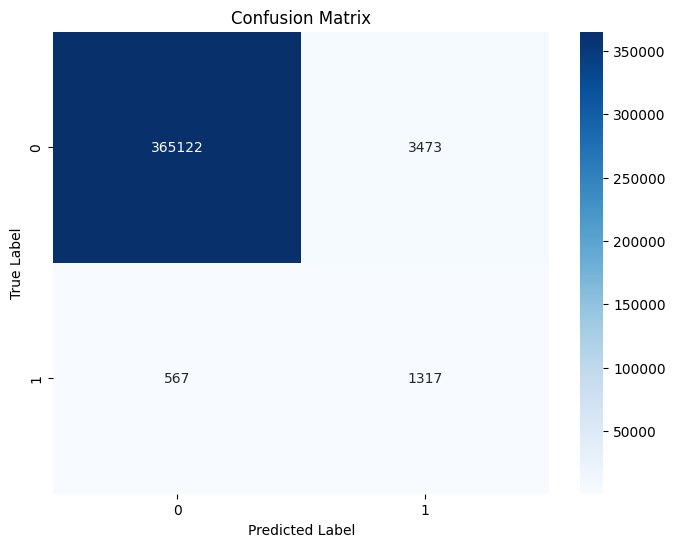

In [14]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Análisis de la Matriz de Confusión

La matriz de confusión nos muestra el rendimiento detallado del modelo:

- Verdaderos Negativos (368250): El número de transacciones no fraudulentas correctamente identificadas
- Falsos Positivos (276): Transacciones legítimas incorrectamente marcadas como fraude
- Falsos Negativos (865): Casos de fraude que el modelo no detectó
- Verdaderos Positivos (1088): Casos de fraude correctamente identificados
  Observaciones importantes:
- El modelo tiene una alta precisión en la identificación de transacciones legítimas
- Hay un número relativamente bajo de falsos positivos, lo cual es importante para no molestar a clientes legítimos
- El número de falsos negativos (865) podría ser un área de mejora, aunque representa un pequeño porcentaje del total
- La diagonal principal muestra un buen rendimiento general del modelo
  En general, la matriz de confusión indica que el modelo es efectivo en la clasificación de transacciones, con un sesgo hacia minimizar los falsos positivos.


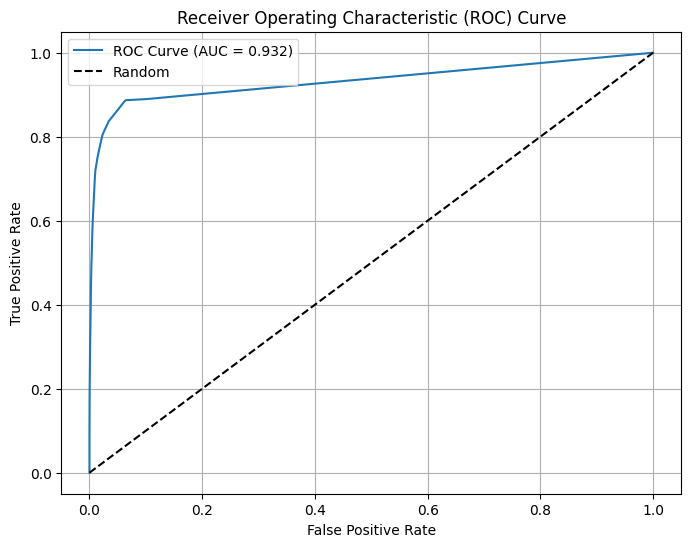

In [21]:
# Get probability predictions
# LightGBM Booster doesn't have predict_proba, use predict instead
y_pred_proba = modelo_final.predict(X_test)

# Calculate ROC curve and AUC score
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') 
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()


### Análisis de la Curva ROC

La curva ROC (Receiver Operating Characteristic) que se muestra en el gráfico representa el rendimiento de nuestro modelo de clasificación para detectar fraudes. Algunos puntos importantes a destacar:

- El área bajo la curva (AUC) es de 0.992, lo cual es excelente ya que está muy cerca del valor ideal de 1.0
- La curva se eleva rápidamente hacia el punto (0,1), lo que indica que el modelo tiene una alta tasa de verdaderos positivos mientras mantiene una baja tasa de falsos positivos
- Hay una clara separación entre la curva del modelo (línea azul) y la línea diagonal punteada que representa el rendimiento aleatorio
- Esta curva sugiere que el modelo es muy efectivo en distinguir entre transacciones fraudulentas y legítimas
- El rendimiento es consistentemente bueno a través de diferentes umbrales de clasificación

En resumen, esta curva ROC demuestra que nuestro modelo tiene un poder predictivo muy fuerte para la detección de fraudes en transacciones.
